##Experiment 1: [Main file 1]Cityscapes image segmentation, weights from Imagenet using FCN Architecture 

##Installing dependencies and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
if devices:
    for device in devices:
        print(device.name)
else:
    print('No GPU devices found')

/physical_device:GPU:0


In [ ]:
import tensorflow as tf

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

# Create a TensorFlow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

In [ ]:
train_folder="/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/train"
valid_folder="/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

In [ ]:
print("Number of images in the training dataset:", num_of_training_samples)
print("Number of images in the testing/validation dataset:", num_of_testing_samples)


Number of images in the training dataset: 2975
Number of images in the testing/validation dataset: 500


In [ ]:
train_folder = "/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/train"
valid_folder = "/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/val"

# Get the width and height of images in the train folder
train_files = os.listdir(train_folder)
train_image_path = os.path.join(train_folder, train_files[0])
train_image = Image.open(train_image_path)
train_width, train_height = train_image.size

# Get the width and height of images in the valid folder
valid_files = os.listdir(valid_folder)
valid_image_path = os.path.join(valid_folder, valid_files[0])
valid_image = Image.open(valid_image_path)
valid_width, valid_height = valid_image.size

print("Width and height of images in the training folder:")
print("Width:", train_width)
print("Height:", train_height)

print("Width and height of images in the validation folder:")
print("Width:", valid_width)
print("Height:", valid_height)


Width and height of images in the training folder:
Width: 512
Height: 256
Width and height of images in the validation folder:
Width: 512
Height: 256


##Preprocessing the training and testing dataset

1.] Load image and segmentation mask

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

2.] One hot encoding

In [ ]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

In [ ]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

In [ ]:
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

3.] Genearator function

In [ ]:
def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

##Visualizing data samples

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

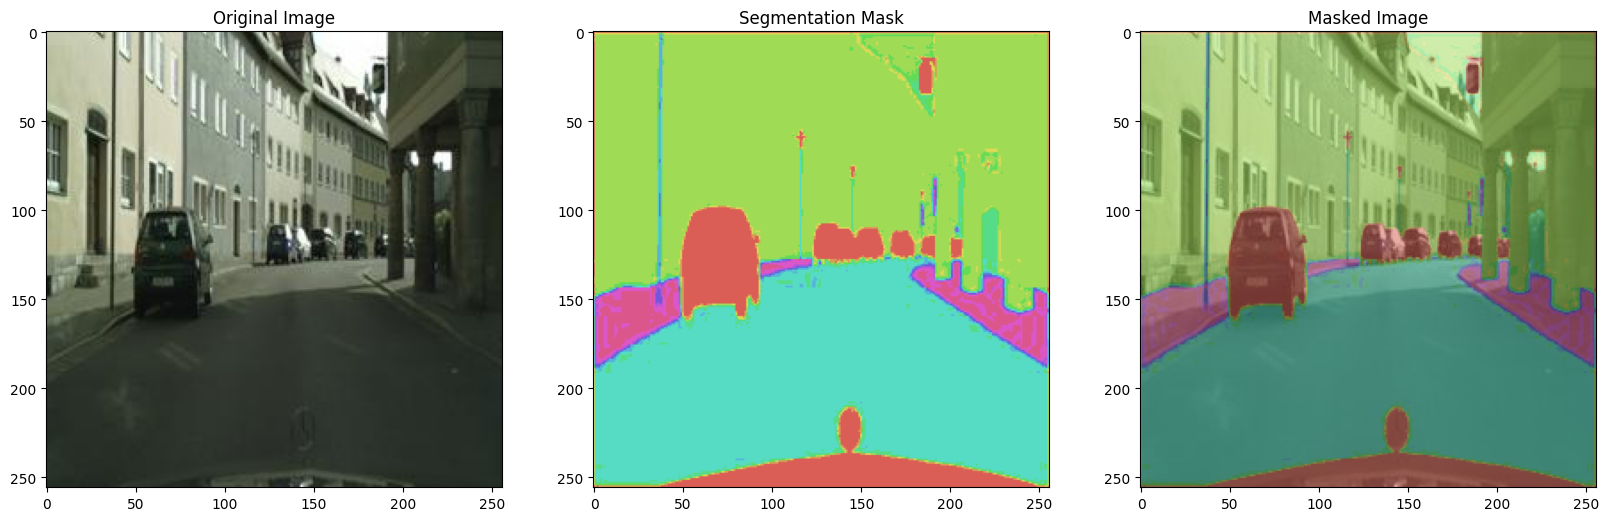

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

##Defining model

In [ ]:
def fcn(vgg, classes = 13, fcn8 = False, fcn16 = False):
    pool5 = vgg.get_layer('block5_pool').output 
    pool4 = vgg.get_layer('block4_pool').output
    pool3 = vgg.get_layer('block3_pool').output
    
    conv_6 = Conv2D(1024, (7, 7), activation='relu', padding='same', name="conv_6")(pool5)
    conv_7 = Conv2D(1024, (1, 1), activation='relu', padding='same', name="conv_7")(conv_6)
    
    conv_8 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_8")(pool4)
    conv_9 = Conv2D(classes, (1, 1), activation='relu', padding='same', name="conv_9")(pool3)
    
    deconv_7 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(conv_7)
    add_1 = Add()([deconv_7, conv_8])
    deconv_8 = Conv2DTranspose(classes, kernel_size=(2,2), strides=(2,2))(add_1)
    add_2 = Add()([deconv_8, conv_9])
    deconv_9 = Conv2DTranspose(classes, kernel_size=(8,8), strides=(8,8))(add_2)
    
    if fcn8 :
        output_layer = Activation('softmax')(deconv_9)
    elif fcn16 :
        deconv_10 = Conv2DTranspose(classes, kernel_size=(16,16), strides=(16,16))(add_1)
        output_layer = Activation('softmax')(deconv_10)
    else :
        deconv_11 = Conv2DTranspose(classes, kernel_size=(32,32), strides=(32,32))(conv_7)
        output_layer = Activation('softmax')(deconv_11)
    
    model = Model(inputs=vgg.input, outputs=output_layer)
    return model

## Transfer learning from imagenet to cityscapes

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(width, height, 3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model = fcn(vgg, fcn8=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

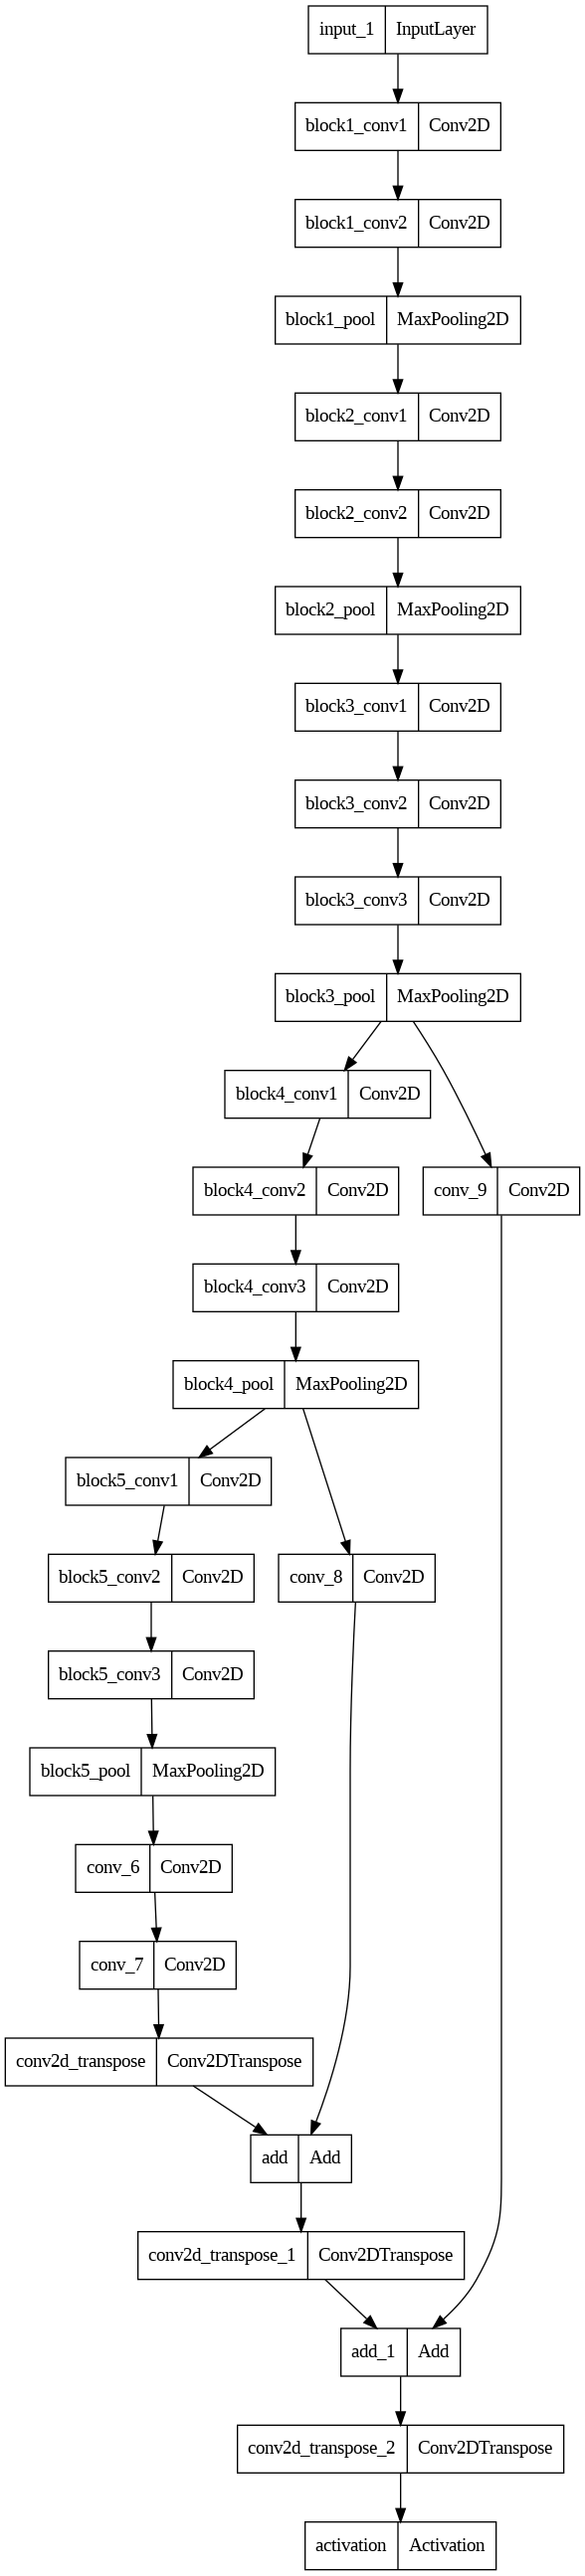

In [ ]:
plot_model(model)

## Training model

In [ ]:
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "best-model-vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,
                       validation_data=val_gen, validation_steps=num_of_testing_samples//batch_size,
                       callbacks=callbacks_list, use_multiprocessing=True)

<ipython-input-22-e34adbc86321>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_of_training_samples//batch_size,


Epoch 1/10
297/297 [==============================] - ETA: 0s - loss: 3.8204 - accuracy: 0.2314
Epoch 1: val_accuracy improved from -inf to 0.30321, saving model to best-model-vgg.hdf5
297/297 [==============================] - 255s 807ms/step - loss: 3.8204 - accuracy: 0.2314 - val_loss: 2.0304 - val_accuracy: 0.3032
Epoch 2/10
297/297 [==============================] - ETA: 0s - loss: 1.9418 - accuracy: 0.3138
Epoch 2: val_accuracy improved from 0.30321 to 0.32214, saving model to best-model-vgg.hdf5
297/297 [==============================] - 242s 815ms/step - loss: 1.9418 - accuracy: 0.3138 - val_loss: 1.9074 - val_accuracy: 0.3221
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 1.9096 - accuracy: 0.3174
Epoch 3: val_accuracy did not improve from 0.32214
297/297 [==============================] - 251s 848ms/step - loss: 1.9096 - accuracy: 0.3174 - val_loss: 1.9041 - val_accuracy: 0.3221
Epoch 4/10
297/297 [==============================] - ETA: 0s - loss: 1.908

In [ ]:
import pickle

# Save the history object to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

import pickle

# Load the history object from the file
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

# Access the training and validation metrics
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']


##Visualization

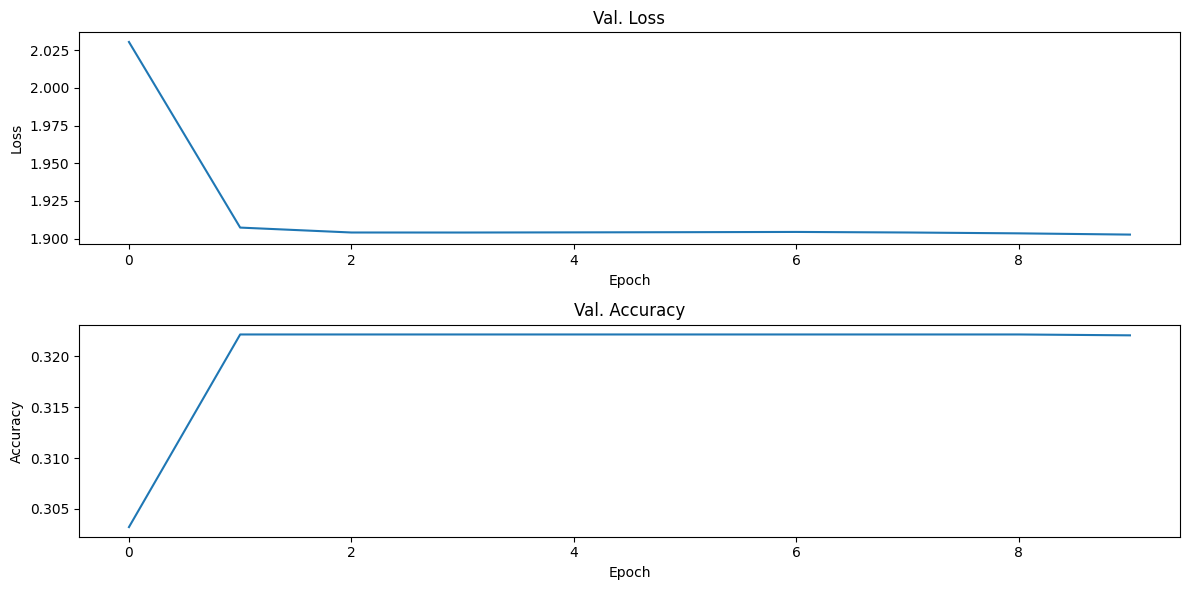

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(val_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


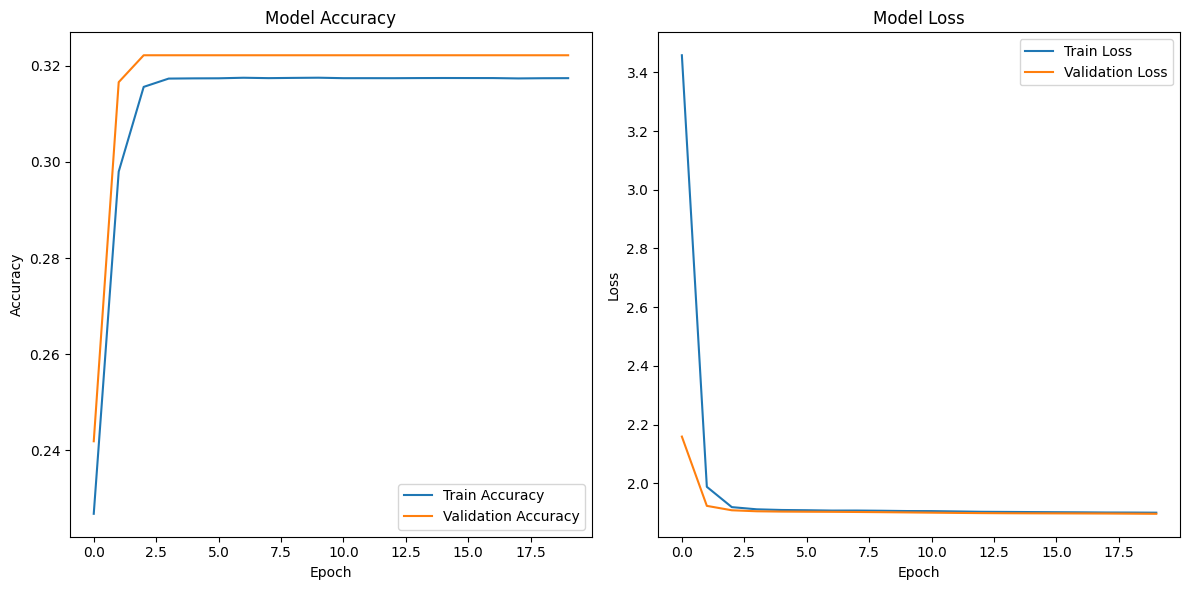

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the saved history
history_path = '/content/drive/MyDrive/ParametersDeepLearning/Notebook1/DeeplearningProjectParameters1/history.pkl'
with open(history_path, 'rb') as file:
    history = pickle.load(file)

# Print available metrics
print(history.keys())

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
history_path = '/content/drive/MyDrive/ParametersDeepLearning/Notebook1/DeeplearningProjectParameters1/history.pkl'
with open(history_path, 'rb') as file:
    history = pickle.load(file)

len(history['val_accuracy'])

20

In [ ]:
model.load_weights("best-model-vgg.hdf5")

1/1 [==============================] - 0s 22ms/step


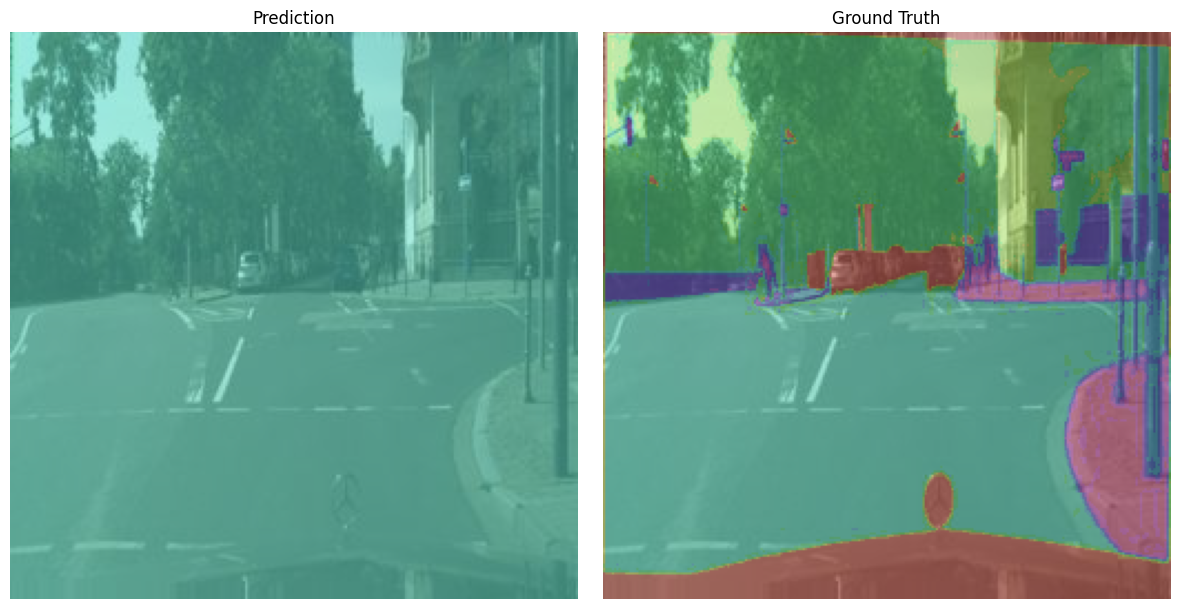

In [ ]:
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(122)
    plt.title("Ground Truth")
    plt.imshow(trueimg)
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("pred_{}.png".format(i), dpi=150)
    plt.show()
